# Frame1-from-frame2 reconstruction with bolus masking

Trains a small image-to-image model to predict frame1 (earlier) from frame2 (later). The loss ignores the bolus region of frame1 using the provided masks. Switch architectures by changing `MODEL_NAME` near the top of the notebook.

In [65]:
from pathlib import Path
from collections import defaultdict
import random
import re
import math

import cv2
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

DATA_ROOT = Path(".")
IMAGES_DIR = DATA_ROOT / "images"
MASKS_DIR = DATA_ROOT / "masks"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
NUM_WORKERS = 0
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
AUGMENT_TRAIN = True
MODEL_NAME = "autoencoder"  # swap to 'unet' to try the skip-connection variant

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
PIN_MEMORY = device.type == "cuda"

print("Using device:", device)

Using device: mps


In [66]:
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")


def parse_frame_key(path: Path):
    match = FILENAME_PATTERN.match(path.stem)
    if not match:
        raise ValueError(f"Unexpected filename: {path.name}")
    return match.group("prefix"), int(match.group("frame"))


def load_gray(path: Path) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(path)
    return image


def collect_frame_pairs(images_dir: Path, masks_dir: Path) -> pd.DataFrame:
    grouped = defaultdict(list)
    for img_path in images_dir.glob("*.png"):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    rows = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_prev, path_prev), (_, path_next) in zip(frames, frames[1:]):
            mask_prev = masks_dir / path_prev.name
            if not mask_prev.exists():
                continue
            rows.append(
                {
                    "frame1": path_prev,
                    "frame2": path_next,
                    "mask1": mask_prev,
                    "sequence": prefix,
                    "frame_idx": idx_prev,
                }
            )
    return pd.DataFrame(rows)


pairs_df = collect_frame_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Total pairs: {len(pairs_df)} from {pairs_df['sequence'].nunique()} sequences")
if len(pairs_df) == 0:
    raise RuntimeError("No frame pairs found. Confirm IMAGES_DIR and MASKS_DIR are populated.")
pairs_df.head()

Total pairs: 6337 from 87 sequences


,frame1,frame2,mask1,sequence,frame_idx
0,images/ns055b554_resized_512.png,images/ns055b556_resized_512.png,masks/ns055b554_resized_512.png,ns055b,554
1,images/ns055b556_resized_512.png,images/ns055b558_resized_512.png,masks/ns055b556_resized_512.png,ns055b,556
2,images/ns055b558_resized_512.png,images/ns055b560_resized_512.png,masks/ns055b558_resized_512.png,ns055b,558
3,images/ns055b560_resized_512.png,images/ns055b562_resized_512.png,masks/ns055b560_resized_512.png,ns055b,560
4,images/ns055b562_resized_512.png,images/ns055b564_resized_512.png,masks/ns055b562_resized_512.png,ns055b,562


In [67]:
seqs = pairs_df["sequence"].unique()
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

splits = {
    "train": pairs_df[pairs_df["sequence"].isin(train_seq)].reset_index(drop=True),
    "val": pairs_df[pairs_df["sequence"].isin(val_seq)].reset_index(drop=True),
    "test": pairs_df[pairs_df["sequence"].isin(test_seq)].reset_index(drop=True),
}

for name, df in splits.items():
    print(f"{name}: {len(df)} samples | sequences: {df['sequence'].nunique()}")

train: 4315 samples | sequences: 60
val: 795 samples | sequences: 13
test: 1227 samples | sequences: 14


In [68]:
class FramePairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        frame1 = load_gray(row["frame1"]).astype(np.float32) / 255.0
        frame2 = load_gray(row["frame2"]).astype(np.float32) / 255.0
        mask1 = load_gray(row["mask1"])
        mask1 = (mask1 > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=1).copy()
                frame2 = np.flip(frame2, axis=1).copy()
                mask1 = np.flip(mask1, axis=1).copy()
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=0).copy()
                frame2 = np.flip(frame2, axis=0).copy()
                mask1 = np.flip(mask1, axis=0).copy()

        frame1_t = torch.from_numpy(frame1).unsqueeze(0)
        frame2_t = torch.from_numpy(frame2).unsqueeze(0)
        mask1_t = torch.from_numpy(mask1).unsqueeze(0)
        return frame2_t, frame1_t, mask1_t


loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

data_loaders = {
    "train": DataLoader(FramePairDataset(splits["train"], augment=AUGMENT_TRAIN), batch_size=TRAIN_BATCH_SIZE, shuffle=True, **loader_kwargs),
    "val": DataLoader(FramePairDataset(splits["val"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
    "test": DataLoader(FramePairDataset(splits["test"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
}

for name, loader in data_loaders.items():
    batch = next(iter(loader))
    f2, f1, m1 = batch
    print(name, "batch shapes:", f2.shape, f1.shape, m1.shape)

train batch shapes: torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])
val batch shapes: torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])
test batch shapes: torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])


In [69]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class TinyUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=(16, 32, 64)):
        super().__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        ch = in_channels
        for feat in features:
            self.downs.append(ConvBlock(ch, feat))
            self.pools.append(nn.MaxPool2d(2))
            ch = feat

        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)

        self.upconvs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        decoder_in = features[-1] * 2
        for feat in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(decoder_in, feat, kernel_size=2, stride=2))
            self.dec_blocks.append(ConvBlock(feat * 2, feat))
            decoder_in = feat

        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skips.append(x)
            x = pool(x)

        x = self.bottleneck(x)
        for upconv, dec, skip in zip(self.upconvs, self.dec_blocks, reversed(skips)):
            x = upconv(x)
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = dec(x)

        return torch.sigmoid(self.final(x))


class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=1, base=32):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, base),
            nn.MaxPool2d(2),
            ConvBlock(base, base * 2),
            nn.MaxPool2d(2),
            ConvBlock(base * 2, base * 4),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base * 4, base * 2, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            ConvBlock(base * 2, base * 2),
            nn.ConvTranspose2d(base * 2, base, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            ConvBlock(base, base),
            nn.Conv2d(base, 1, kernel_size=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.sigmoid(x)


MODEL_BUILDERS = {
    "autoencoder": lambda: ConvAutoencoder(in_channels=1, base=32),
    "unet": lambda: TinyUNet(in_channels=1, out_channels=1, features=(16, 32, 64)),
}

if MODEL_NAME not in MODEL_BUILDERS:
    raise KeyError(f"Unknown MODEL_NAME '{MODEL_NAME}'. Choose from: {list(MODEL_BUILDERS)}")

model = MODEL_BUILDERS[MODEL_NAME]().to(device)
print(f"Model '{MODEL_NAME}' params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Model 'autoencoder' params: 0.42M


In [70]:
def masked_l1_loss(pred, target, mask, eps=1e-8):
    valid = 1.0 - mask
    denom = valid.sum(dim=(1, 2, 3)).clamp_min(eps)
    loss = (valid * (pred - target).abs()).sum(dim=(1, 2, 3)) / denom
    return loss.mean()


def masked_mse(pred, target, mask, eps=1e-8):
    valid = 1.0 - mask
    denom = valid.sum(dim=(1, 2, 3)).clamp_min(eps)
    mse = (valid * (pred - target) ** 2).sum(dim=(1, 2, 3)) / denom
    return mse


def psnr_from_mse(mse_tensor):
    return (10 * torch.log10(1.0 / torch.clamp(mse_tensor, min=1e-10))).mean()


def to_device(batch):
    return [b.to(device) for b in batch]

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
history = []
best_state = None
best_val_loss = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_losses = []

    for frame2, frame1, mask1 in tqdm(data_loaders["train"], desc=f"Epoch {epoch} [train]"):
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        pred = model(frame2)
        loss = masked_l1_loss(pred, frame1, mask1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses)) if train_losses else float("nan")

    model.eval()
    val_losses = []
    val_psnr = []
    with torch.no_grad():
        for frame2, frame1, mask1 in data_loaders["val"]:
            frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
            pred = model(frame2)
            loss = masked_l1_loss(pred, frame1, mask1)
            mse = masked_mse(pred, frame1, mask1)
            val_losses.append(loss.item())
            val_psnr.append(psnr_from_mse(mse).item())

    val_loss = float(np.mean(val_losses)) if val_losses else float("nan")
    val_psnr_mean = float(np.mean(val_psnr)) if val_psnr else float("nan")
    history.append(dict(epoch=epoch, train_loss=train_loss, val_loss=val_loss, val_psnr=val_psnr_mean))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch}: train L1={train_loss:.4f} | val L1={val_loss:.4f} | val PSNR={val_psnr_mean:.2f}")

print("Best val L1:", best_val_loss)

Epoch 1 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 1: train L1=0.0213 | val L1=0.0131 | val PSNR=29.94


Epoch 2 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 2: train L1=0.0143 | val L1=0.0133 | val PSNR=30.65


Epoch 3 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 3: train L1=0.0114 | val L1=0.0140 | val PSNR=29.36


Epoch 4 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 4: train L1=0.0096 | val L1=0.0065 | val PSNR=34.97


Epoch 5 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 5: train L1=0.0093 | val L1=0.0081 | val PSNR=34.42


Epoch 6 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 6: train L1=0.0085 | val L1=0.0081 | val PSNR=35.62


Epoch 7 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 7: train L1=0.0079 | val L1=0.0056 | val PSNR=37.49


Epoch 8 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 8: train L1=0.0077 | val L1=0.0076 | val PSNR=35.69


Epoch 9 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 9: train L1=0.0075 | val L1=0.0081 | val PSNR=36.77


Epoch 10 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 10: train L1=0.0075 | val L1=0.0078 | val PSNR=36.70


Epoch 11 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 11: train L1=0.0072 | val L1=0.0088 | val PSNR=34.91


Epoch 12 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 12: train L1=0.0070 | val L1=0.0054 | val PSNR=38.08


Epoch 13 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 13: train L1=0.0071 | val L1=0.0068 | val PSNR=36.52


Epoch 14 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 14: train L1=0.0069 | val L1=0.0060 | val PSNR=37.27


Epoch 15 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 15: train L1=0.0069 | val L1=0.0072 | val PSNR=36.20


Epoch 16 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 16: train L1=0.0069 | val L1=0.0095 | val PSNR=34.31


Epoch 17 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 17: train L1=0.0068 | val L1=0.0057 | val PSNR=37.88


Epoch 18 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 18: train L1=0.0066 | val L1=0.0055 | val PSNR=38.24


Epoch 19 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 19: train L1=0.0066 | val L1=0.0083 | val PSNR=34.92


Epoch 20 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

Epoch 20: train L1=0.0066 | val L1=0.0070 | val PSNR=36.63
Best val L1: 0.005433957243803888


Test masked L1: 0.0056 | Test PSNR: 38.57


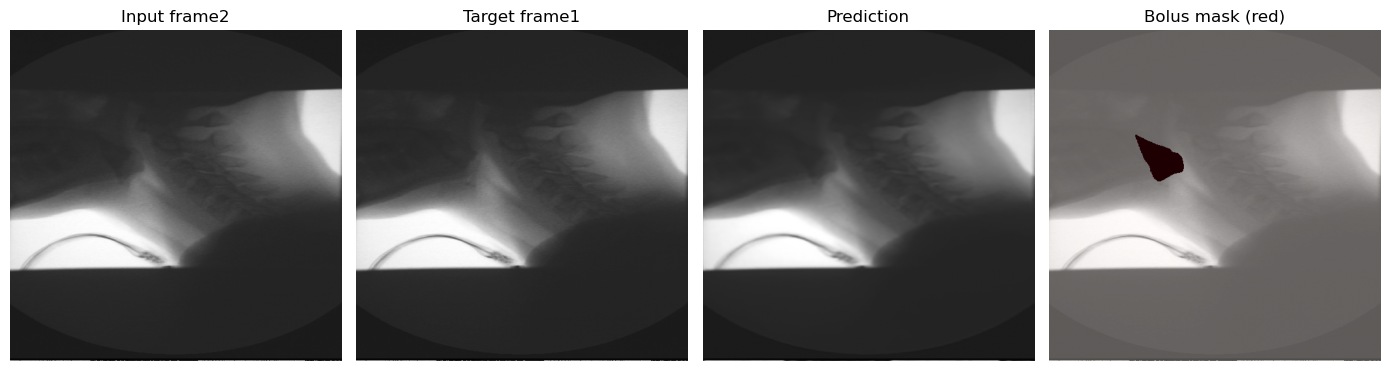

In [72]:
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

model.eval()
test_losses = []
test_psnr = []
with torch.no_grad():
    for frame2, frame1, mask1 in data_loaders["test"]:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        pred = model(frame2)
        loss = masked_l1_loss(pred, frame1, mask1)
        mse = masked_mse(pred, frame1, mask1)
        test_losses.append(loss.item())
        test_psnr.append(psnr_from_mse(mse).item())

print(
    f"Test masked L1: {float(np.mean(test_losses)) if test_losses else float('nan'):.4f} | "
    f"Test PSNR: {float(np.mean(test_psnr)) if test_psnr else float('nan'):.2f}"
)

# quick qualitative sample (uses test split when available)
target_loader = data_loaders["test"] if len(splits["test"]) else data_loaders["val"]
with torch.no_grad():
    sample_batch = next(iter(target_loader))
    frame2, frame1, mask1 = [t.to(device) for t in sample_batch]
    pred = model(frame2).cpu().numpy()
    frame2 = frame2.cpu().numpy()
    frame1 = frame1.cpu().numpy()
    mask1 = mask1.cpu().numpy()

idx = 0
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(frame2[idx, 0], cmap="gray")
axes[0].set_title("Input frame2")
axes[1].imshow(frame1[idx, 0], cmap="gray")
axes[1].set_title("Target frame1")
axes[2].imshow(pred[idx, 0], cmap="gray", vmin=0, vmax=1)
axes[2].set_title("Prediction")
axes[3].imshow(frame1[idx, 0] * (1 - mask1[idx, 0]), cmap="gray")
axes[3].imshow(mask1[idx, 0], cmap="Reds", alpha=0.3)
axes[3].set_title("Bolus mask (red)")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [73]:
torch.save(model.state_dict(), 'my_model_weights.pth')

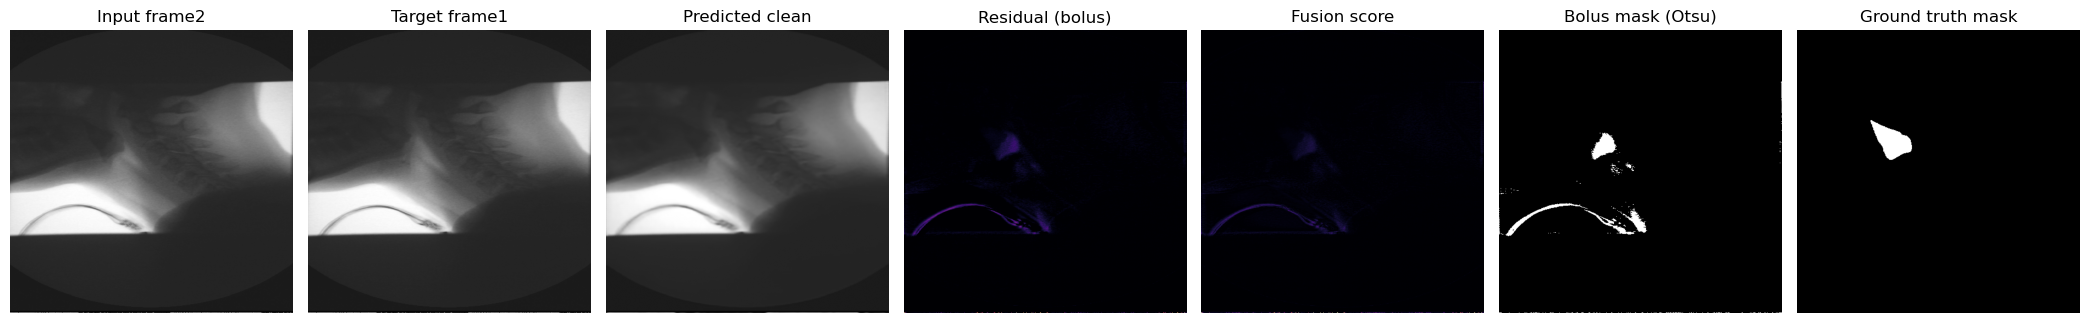

In [74]:
# Load saved weights and estimate bolus mask via frame fusion
CKPT_PATH = Path("my_model_weights.pth")

if not CKPT_PATH.exists():
    raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# prefer test loader if available
target_loader = data_loaders["test"] if len(splits["test"]) else data_loaders["val"]
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    pred_clean = model(frame2).clamp(0, 1)
    residual = (frame1 - pred_clean).clamp(min=0)  # expected bolus contribution
    fusion = (residual + (frame2 - pred_clean).abs()).clamp(0, 1)

idx = 0
res_img = (residual[idx, 0].cpu().numpy() * 255).astype(np.uint8)
_, bolus_mask = cv2.threshold(res_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(1, 7, figsize=(21, 4))
axes[0].imshow(frame2[idx, 0].cpu(), cmap="gray"); axes[0].set_title("Input frame2")
axes[1].imshow(frame1[idx, 0].cpu(), cmap="gray"); axes[1].set_title("Target frame1")
axes[2].imshow(pred_clean[idx, 0].cpu(), cmap="gray", vmin=0, vmax=1); axes[2].set_title("Predicted clean")
axes[3].imshow(residual[idx, 0].cpu(), cmap="magma"); axes[3].set_title("Residual (bolus)")
axes[4].imshow(fusion[idx, 0].cpu(), cmap="magma"); axes[4].set_title("Fusion score")
axes[5].imshow(bolus_mask, cmap="gray"); axes[5].set_title("Bolus mask (Otsu)")
axes[6].imshow(mask1[idx, 0].cpu(), cmap="gray"); axes[6].set_title("Ground truth mask")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()


[Attn] Epoch 1:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 1 BCE: 0.5122 | Dice: 0.5303


[Attn] Epoch 2:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 2 BCE: 0.3147 | Dice: 0.5684


[Attn] Epoch 3:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 3 BCE: 0.2915 | Dice: 0.5028


[Attn] Epoch 4:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 4 BCE: 0.2790 | Dice: 0.3253


[Attn] Epoch 5:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 5 BCE: 0.2719 | Dice: 0.4310


[Attn] Epoch 6:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 6 BCE: 0.2658 | Dice: 0.5494


[Attn] Epoch 7:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 7 BCE: 0.2587 | Dice: 0.4487


[Attn] Epoch 8:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 8 BCE: 0.2551 | Dice: 0.3280


[Attn] Epoch 9:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 9 BCE: 0.2508 | Dice: 0.5532


[Attn] Epoch 10:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 10 BCE: 0.2454 | Dice: 0.4325


[Attn] Epoch 11:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 11 BCE: 0.2416 | Dice: 0.4631


[Attn] Epoch 12:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 12 BCE: 0.2392 | Dice: 0.6060


[Attn] Epoch 13:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 13 BCE: 0.2366 | Dice: 0.1896


[Attn] Epoch 14:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 14 BCE: 0.2335 | Dice: 0.6671


[Attn] Epoch 15:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 15 BCE: 0.2306 | Dice: 0.7497


[Attn] Epoch 16:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 16 BCE: 0.2295 | Dice: 0.4647


[Attn] Epoch 17:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 17 BCE: 0.2271 | Dice: 0.5011


[Attn] Epoch 18:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 18 BCE: 0.2233 | Dice: 0.2182


[Attn] Epoch 19:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 19 BCE: 0.2222 | Dice: 0.3492


[Attn] Epoch 20:   0%|          | 0/540 [00:00<?, ?it/s]

[Attn] Epoch 20 BCE: 0.2198 | Dice: 0.2731


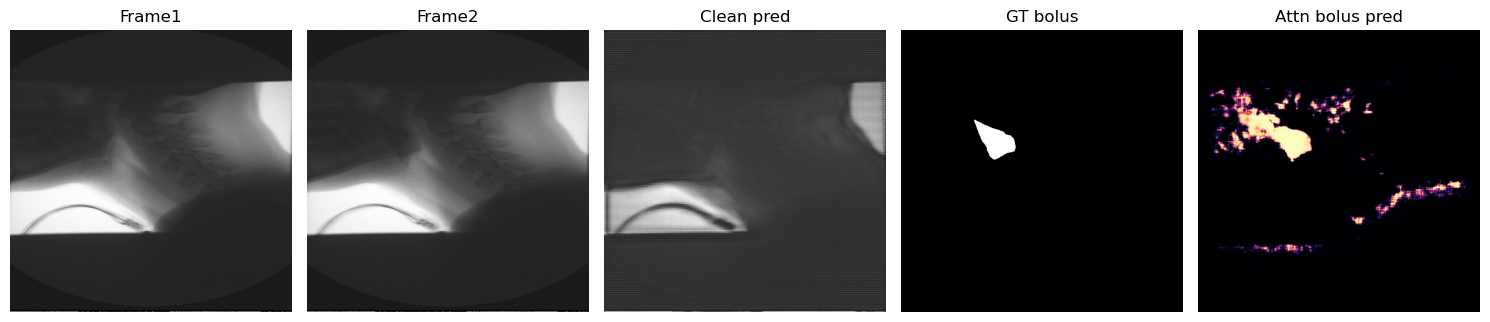

In [75]:
# Attention fusion model: frame1 + frame2 + clean prediction -> bolus mask (joint fine-tuning)
ATTN_EPOCHS = 20  # increase for better results
ATTN_LR = 1e-3
CLEAN_LR = 1e-4  # smaller LR for the clean frame model when unfrozen
DICE_WEIGHT = 0.5  # blend BCE + Dice

class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int = 8):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, mid, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, channels, kernel_size=1, bias=False),
        )

    def forward(self, x):
        avg_out = self.mlp(F.adaptive_avg_pool2d(x, 1))
        max_out = self.mlp(F.adaptive_max_pool2d(x, 1))
        scale = torch.sigmoid(avg_out + max_out)
        return x * scale


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_val, _ = torch.max(x, dim=1, keepdim=True)
        scale = torch.sigmoid(self.conv(torch.cat([avg, max_val], dim=1)))
        return x * scale


class AttentionBolusNet(nn.Module):
    def __init__(self, base: int = 32):
        super().__init__()
        self.stem = ConvBlock(3, base)
        self.fuse = ConvBlock(base, base)
        self.chan = ChannelAttention(base)
        self.spatial = SpatialAttention()
        self.head = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        h = self.stem(x)
        h = self.chan(h)
        h = self.fuse(h)
        h = self.spatial(h)
        return torch.sigmoid(self.head(h))


# train a small attention model and fine-tune the clean-frame model jointly
attn_model = AttentionBolusNet(base=32).to(device)
attn_optimizer = torch.optim.Adam(
    [
        {"params": attn_model.parameters(), "lr": ATTN_LR},
        {"params": model.parameters(), "lr": CLEAN_LR},
    ]
)
bce_loss = nn.BCELoss()

def dice_loss_binary(prob, target, eps: float = 1e-6):
    # prob, target: [B,1,H,W]
    inter = (prob * target).sum(dim=(1, 2, 3))
    denom = prob.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * inter + eps) / (denom + eps)
    return 1 - dice.mean()


for epoch in range(1, ATTN_EPOCHS + 1):
    model.train()
    attn_model.train()
    losses = []
    progress = tqdm(data_loaders["train"], desc=f"[Attn] Epoch {epoch}", leave=False)
    for frame2, frame1, mask1 in progress:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        fused = torch.cat([frame1, frame2, clean_pred], dim=1)
        prob = attn_model(fused).clamp(0, 1)

        loss_bce = bce_loss(prob, mask1)
        loss_dice = dice_loss_binary(prob, mask1)
        loss = loss_bce + DICE_WEIGHT * loss_dice

        attn_optimizer.zero_grad()
        loss.backward()
        attn_optimizer.step()
        losses.append(loss.item())
        progress.set_postfix(loss=f"{loss.item():.4f}")
    print(f"[Attn] Epoch {epoch} BCE: {float(np.mean(losses)):.4f} | Dice: {loss_dice.item():.4f}")

# quick eval/visualization
model.eval()
attn_model.eval()
target_loader = data_loaders["test"] if len(splits["test"]) else data_loaders["val"]
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    clean_pred = model(frame2).clamp(0, 1)
    fused = torch.cat([frame1, frame2, clean_pred], dim=1)
    bolus_pred = attn_model(fused)

idx = 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
axes[0].imshow(frame1[idx, 0].cpu(), cmap="gray"); axes[0].set_title("Frame1")
axes[1].imshow(frame2[idx, 0].cpu(), cmap="gray"); axes[1].set_title("Frame2")
axes[2].imshow(clean_pred[idx, 0].cpu(), cmap="gray", vmin=0, vmax=1); axes[2].set_title("Clean pred")
axes[3].imshow(mask1[idx, 0].cpu(), cmap="gray"); axes[3].set_title("GT bolus")
axes[4].imshow(bolus_pred[idx, 0].cpu(), cmap="magma", vmin=0, vmax=1); axes[4].set_title("Attn bolus pred")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()


In [76]:
torch.save(attn_model.state_dict(), 'attn_model_weights2.pth')

In [77]:
# Evaluate attention bolus model: IoU, Dice (DSC), AUC
from sklearn.metrics import roc_auc_score

attn_model.eval()
target_loader = data_loaders["test"] if len(splits["test"]) else data_loaders["val"]

total_iou = []
total_dice = []
all_probs = []
all_targets = []

with torch.no_grad():
    for frame2, frame1, mask1 in target_loader:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        fused = torch.cat([frame1, frame2, clean_pred], dim=1)
        bolus_pred = attn_model(fused).clamp(0, 1)

        pred_bin = (bolus_pred >= 0.5).float()
        intersection = (pred_bin * mask1).sum(dim=(1, 2, 3))
        union = pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3)) - intersection
        dice = (2 * intersection) / (pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3))).clamp_min(1e-6)
        iou = intersection / union.clamp_min(1e-6)

        total_iou.extend(iou.cpu().numpy().tolist())
        total_dice.extend(dice.cpu().numpy().tolist())
        all_probs.append(bolus_pred.cpu().numpy().reshape(-1))
        all_targets.append(mask1.cpu().numpy().reshape(-1))

all_probs = np.concatenate(all_probs) if all_probs else np.array([])
all_targets = np.concatenate(all_targets) if all_targets else np.array([])

if all_probs.size == 0:
    auc = float("nan")
elif np.unique(all_targets).size < 2:
    auc = float("nan")
else:
    auc = roc_auc_score(all_targets, all_probs)

print(
    f"Attn IoU: {float(np.mean(total_iou)) if total_iou else float('nan'):.4f} | "
    f"Attn Dice: {float(np.mean(total_dice)) if total_dice else float('nan'):.4f} | "
    f"Attn AUC: {auc if not np.isnan(auc) else float('nan'):.4f}"
)


Attn IoU: 0.4376 | Attn Dice: 0.5571 | Attn AUC: 0.9854
